# Imports

In [57]:
import numpy as np
import pandas as pd
import madmom as mm
import librosa as lr
import pretty_midi as pm
import librosa.display as display
import IPython.display as ipd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Reshape, Conv2D, Dense, Dropout, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD


# Constants

In [35]:
DATAPOINT = "../datasets/ISOL/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/ISOL/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"
WINDOW_SIZE = 5

# Preprocess

#### Generate spectrogram:

In [36]:
logSpect = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1,
    sr=44100,
#     unique_filters=False,
    norm_filters=True
)

In [37]:
logSpect.shape

(2186, 236)

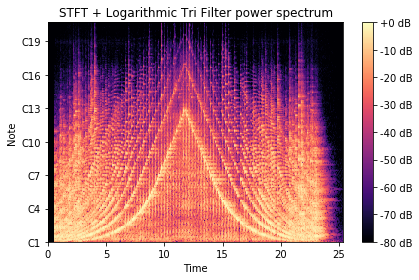

In [38]:
lr.display.specshow(
    lr.amplitude_to_db(logSpect, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

#### Normalize, Rescale, and Pad:

In [39]:
logSpect = np.nan_to_num(logSpect)

In [40]:
logSpect = np.abs(logSpect)

In [41]:
logSpect /= np.max(logSpect, axis=0)

In [42]:
logSpect = np.pad(
    logSpect, 
    ((WINDOW_SIZE//2, WINDOW_SIZE//2), (0,0)), 
    'constant')

In [43]:
logSpect.shape

(2190, 236)

#### Generate windows:

In [44]:
windows = []

for i in range(logSpect.shape[0] - WINDOW_SIZE + 1):
    w = logSpect[i:i+WINDOW_SIZE,:]
    windows.append(w)

cleanDatapoints = np.array(windows)

#### Generate ground truth:

In [45]:
times = lr.frames_to_time(
    np.arange(logSpect.shape[0]),
    sr=44100,
    hop_length=441.0)

In [46]:
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [47]:
expected = midi.get_piano_roll(fs=44100, times=times).T

In [48]:
expected[expected > 0] = 1

Sanity check input to output shape:

In [49]:
expected.shape

(2190, 128)

In [50]:
logSpect.shape

(2190, 236)

In [51]:
cleanDatapoints[0].shape

(5, 236)

# Compile and Train Model

In [79]:
# inputShape = cleanDatapoints[0].shape
inputShape = (236, 5)
inputShapeDimensions = (logSpect.shape[1], 1)
# inputShapeDimensions = (WINDOW_SIZE, logSpect.shape[1], 1)

In [80]:
print inputShape
print inputShapeDimensions

(5, 236)
(5, 236, 1)


In [81]:
# Layers
input = Input(inputShape)
reshape = Reshape(inputShapeDimensions)(input)
conv1 = Conv2D(32, (3, 3), activation='relu')(reshape)
conv2 = Conv2D(32, (3, 3), activation='relu')(conv1)
batchNorm = BatchNormalization()(conv2)
maxPool1 = MaxPooling2D(pool_size=(1, 2))(batchNorm)
dropOut1 = Dropout(0.25)(maxPool1)
conv3 = Conv2D(64, (3, 3), activation='relu')(dropOut1)
maxPool2 = MaxPooling2D(pool_size=(1, 2))(conv3)
dropOut2 = Dropout(0.25)(maxPool2)
dense1 = Dense(512, activation='relu')(dropOut2)
dropOut3 = Dropout(0.5)(dense1)
output = Dense(88, activation='relu')(dropOut3)

# Result
baseline = Model(inputs=input, outputs=output)

ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_53/convolution' (op: 'Conv2D') with input shapes: [?,1,116,32], [3,3,32,64].

In [62]:
# TODO: lr hardcoded
baseline.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.1,momentum=0.9))